## Imports e instalación de paquetes necesarios

In [2]:
%pip install -q networkx
%pip install -q matplotlib seaborn numpy
%pip install -q cdlib

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 23.3.2
[notice] To update, run: C:\Users\el_su\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 23.3.2
[notice] To update, run: C:\Users\el_su\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 23.3.2
[notice] To update, run: C:\Users\el_su\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [3]:
import copy
import math
import random
import numpy as np
import seaborn as sns
import networkx as nx
import matplotlib.pyplot as plt

from cdlib.classes.node_clustering import NodeClustering
from cdlib import viz

## Create

In [4]:
amazon_G = nx.read_graphml('./amazon_graph.graphml')

# Minimizar la distancia entre los nodos dentro de una comunidad
# Maximizar la distancia entre los nodos de disintas comunidades

In [5]:
def create_individuo(nodes_of_graph, adj_matrix, transformation):
    individuo =  [None] * len(nodes_of_graph)
    for i in range(len(nodes_of_graph)): #el individuo creado con el tipo locus tiene la longitud de los nodos

        
        nodo_vecino = random.choice(range(len(adj_matrix[i]))) #la matriz de adyacencia tiene los nodos vecinos, los nodos vecinos hay que convertirlos a numeros
        while adj_matrix[i][nodo_vecino] == 0 and nodo_vecino != i:
            nodo_vecino = random.choice(range(len(adj_matrix[nodo_vecino])))
        
        
        keys = list(transformation.keys())
        values = list(transformation.values())
        individuo[i] = keys[values.index(nodo_vecino)] # en el gen se pone el aleatorio de los vecinos pero transformado en el indice que le corresponde 
    return individuo

def create(nodes_of_graph, adj_matrix, transformation, N=100): # crea población, la transformacion debe de ser del tipo { numero_de_nodo_real : indice_del_array}, donde el indice del array va de 0 a len(nodos) - 1
    new_population = []
    for individuo in range(N):
        new_population.append(create_individuo(nodes_of_graph, adj_matrix, transformation))
    
    return new_population

In [6]:
conversiones = {}
for i, nodo in enumerate(amazon_G.nodes):
    conversiones[nodo] = i
print(conversiones)

{'75780': 0, '317458': 1, '186386': 2, '419862': 3, '176159': 4, '204831': 5, '104481': 6, '57383': 7, '401449': 8, '299055': 9, '176184': 10, '542780': 11, '366654': 12, '124992': 13, '16457': 14, '196682': 15, '546890': 16, '546891': 17, '34895': 18, '321619': 19, '112724': 20, '276567': 21, '55386': 22, '374874': 23, '55388': 24, '221281': 25, '432229': 26, '104553': 27, '383087': 28, '335987': 29, '448649': 30, '522378': 31, '59532': 32, '491667': 33, '518306': 34, '309411': 35, '182435': 36, '204966': 37, '532649': 38, '544939': 39, '542899': 40, '172218': 41, '270524': 42, '250046': 43, '204991': 44, '231620': 45, '497867': 46, '186575': 47, '346322': 48, '399572': 49, '276695': 50, '530647': 51, '18650': 52, '252125': 53, '59613': 54, '127199': 55, '379102': 56, '159972': 57, '366824': 58, '116969': 59, '202986': 60, '430314': 61, '350442': 62, '4328': 63, '458993': 64, '30962': 65, '35067': 66, '57600': 67, '217346': 68, '295177': 69, '49424': 70, '278': 71, '123159': 72, '3218

Conseguimos la matriz de aristas ya que la necesitaremos para crear la población inicial

In [7]:
A = nx.to_numpy_array(amazon_G)

In [8]:
pop = create(amazon_G.nodes, A, conversiones, N = 100)

In [9]:
def convert_individuo(individuo_raw, conversiones):
    new_individuo = [None] * len(individuo_raw)
    for i in range(len(individuo_raw)):
        new_individuo[i] = conversiones.get(str(individuo_raw[i]))
    
    return new_individuo
def unconvert_individuo(individuo, conversiones):
    individuo_raw =  [None] * len(individuo)
    keys = list(conversiones.keys())
    values = list(conversiones.values())
    for i in range(len(individuo)):
        individuo_raw[i] = keys[values.index(individuo[i])]
    return individuo_raw

def get_comunidades(individuo):

    G = nx.Graph()

    for i in range(len(individuo)):
        G.add_edge(i, individuo[i])

    comunidades = list(nx.connected_components(G))
    return comunidades

def get_cs(aristas_of_min_one_node_in_comunity, nodos_de_la_comunidad):
    cs = 0
    for aristas in aristas_of_min_one_node_in_comunity:
        if aristas[0] in nodos_de_la_comunidad and aristas[1] not in nodos_de_la_comunidad:
            cs += 1
            
        #elif aristas[1] in nodos_de_la_comunidad and aristas[0] not in nodos_de_la_comunidad:
        #    cs += 1
    return cs

def get_ms(aristas_of_min_one_node_in_comunity, nodos_de_la_comunidad):
    ms = 0
    for aristas in aristas_of_min_one_node_in_comunity:
        if aristas[0] in nodos_de_la_comunidad and aristas[1] in nodos_de_la_comunidad:
            ms += 1
            
        
    return ms

## Funciones de fitness

### Conductance
Mide la fracción de las aristas que apuntan fuera del cluster, por lo tanto cuanto menor sea este valor más cohesionado estará este.

In [10]:
def fit_conductance(grafo,individuo,conversiones):
    conductance = 0
    individuo_converted = convert_individuo(individuo, conversiones)
    comunidades = get_comunidades(individuo_converted)
    for comunidad in comunidades:
        aristas_of_min_one_node_in_comunity = []
        comunidad_desconvertida = unconvert_individuo(list(comunidad), conversiones)
        for nodo_of_comunity in comunidad_desconvertida:
            aristas_of_min_one_node_in_comunity.append(list(grafo.edges(str(nodo_of_comunity)))[0])
        # aqui ya tenemos las aristas de los nodos para poder sacar el sm
        cs_community = get_cs(aristas_of_min_one_node_in_comunity, comunidad_desconvertida)
        ms_community = get_ms(aristas_of_min_one_node_in_comunity, comunidad_desconvertida)
        conductance += cs_community / (2*ms_community + cs_community)
    return conductance

### Expansion

Mide el número de aristas que apuntan fuera del clúster, por lo tanto cuanto menor sea este valor más cohesionado estará este.

In [11]:
def fit_expansion(grafo,individuo,conversiones):
    expansion = 0
    individuo_converted = convert_individuo(individuo, conversiones)
    comunidades = get_comunidades(individuo_converted)
    for comunidad in comunidades:
        aristas_of_min_one_node_in_comunity = []
        comunidad_desconvertida = unconvert_individuo(list(comunidad), conversiones)
        for nodo_of_comunity in comunidad_desconvertida:

            aristas_of_min_one_node_in_comunity.append(list(grafo.edges(str(nodo_of_comunity)))[0])
        # aqui ya tenemos las aristas de los nodos para poder sacar el sm
        cs_community = get_cs(aristas_of_min_one_node_in_comunity, comunidad_desconvertida)
        ns_community = len(comunidad_desconvertida)
        expansion += cs_community / ns_community
    
    return expansion

### Average ODF

Mide la media de las fracciones de las aristas que apuntan fuera de este, por lo tanto cuanto menor sea este valor más cohesionado estará el clúster.

In [12]:
def fit_average_odf(grafo,individuo,conversiones):
    average_odf = 0
    individuo_converted = convert_individuo(individuo, conversiones)
    comunidades = get_comunidades(individuo_converted)
    for comunidad in comunidades:
        comunidad_desconvertida = unconvert_individuo(list(comunidad), conversiones)
        sum_nodos = 0
        for nodo_of_comunity in comunidad_desconvertida:
            aristas_del_nodo = list(grafo.edges(str(nodo_of_comunity)))[0]
            
            sum_nodos += get_cs(aristas_del_nodo,nodo_of_comunity) / len(aristas_del_nodo)
        average_odf += sum_nodos / len(comunidad)    
    return average_odf

### Q

Mide el número de aristas internas que tiene un clúster, por lo tanto cuanto mayor sea este valor más cohesionado estará el cluster.

In [13]:
def fit_Q(grafo,individuo,conversiones):
    Q = 0
    individuo_converted = convert_individuo(individuo, conversiones)
    comunidades = get_comunidades(individuo_converted)
    for comunidad in comunidades:
        aristas_of_min_one_node_in_comunity = []
        comunidad_desconvertida = unconvert_individuo(list(comunidad), conversiones)
        n_aristas = 0
        for nodo_of_comunity in comunidad_desconvertida:
            n_aristas += len(list(grafo.edges(str(nodo_of_comunity)))[0])
            aristas_of_min_one_node_in_comunity.append(list(grafo.edges(str(nodo_of_comunity)))[0])
        
        ms_community = get_ms(aristas_of_min_one_node_in_comunity, comunidad_desconvertida)
        cs_community = get_cs(aristas_of_min_one_node_in_comunity, comunidad_desconvertida)
        
        Q += ((ms_community/n_aristas) - (((ms_community + cs_community)/(2*n_aristas))**2))
    
    return Q

## Funciones auxiliares del genético

### Select
Devuelve un individuo seleccionado por torneo, devuelve una copia para evitar efectos laterales

In [14]:
def select (pop, T): 
    seleccionados = random.sample(pop, T)
    return copy.copy(pop[min([pop.index(x) for x in seleccionados])])

### Mutate

La mutación consistirá en cambiar un elemento por otro posible nodo con el que este conectado

In [15]:
def mutate (grafo, ind, pmut, transformation):
    probs = [random.random() for prob in range(len(ind))]
    nuevo_elem = copy.copy(ind)
    adj_matrix = nx.to_numpy_array(grafo)
    for i, probability in enumerate(probs):
      if probability < pmut:
            
        nodo_vecino = random.choice(range(len(adj_matrix[i]))) #la matriz de adyacencia tiene los nodos vecinos, los nodos vecinos hay que convertirlos a numeros
        
        while adj_matrix[i][nodo_vecino] == 0 and nodo_vecino != i:
            nodo_vecino = random.choice(range(len(adj_matrix[nodo_vecino])))
        
        keys = list(transformation.keys())
        values = list(transformation.values())
        nuevo_elem[i] = keys[values.index(nodo_vecino)] # en el gen se pone el aleatorio de los vecinos pero transformado en el indice que le corresponde 
    return nuevo_elem

### Crossover

Realiza el cruce genético entre dos individuos, intercambiando segmentos de sus cromosomas.

In [16]:
def crossover (ind1, ind2, pcross, n_puntos = 1):
    copia_in1 = copy.copy(ind1)
    copia_in2 = copy.copy(ind2)
    if random.random() < pcross:
      punto = len(ind1) // (n_puntos+1)
      for i in range(n_puntos):
        index_fin = punto*(i+2)
        index_inicio = punto*(i+1)
        if index_fin < len(ind1):
          aux = copia_in1[index_inicio:index_fin]
          copia_in1[index_inicio:index_fin] = copia_in2[index_inicio:index_fin]
          copia_in2[index_inicio:index_fin] = aux
        else:
          aux = copia_in1[index_inicio:]
          copia_in1[index_inicio:] = copia_in2[index_inicio:]
          copia_in2[index_inicio:] = aux
    return copia_in1, copia_in2

### Dominates

Determina si un individuo domina a otro.

In [17]:
def dominates(individual_A, individual_B):
    if all(a <= b for a, b in zip(individual_A, individual_B)):
        if any(a < b for a, b in zip(individual_A, individual_B)):
            return True
    return False

### Get Pareto front

Obtiene el frente de Pareto de una población.

In [18]:
def get_pareto_front(pop, fits):
    pareto_front = []
    pareto_fits = []
    for i, fit in enumerate(fits):
        if not any(dominates(fit, fits[j]) for j in range(len(pop)) if i != j):
            pareto_front.append(pop[i])
            pareto_fits.append(fits[i])
    return pareto_front, pareto_fits

### Sort pop


Ordena la población de la siguiente forma:
1. Calcula el frente de pareto
2. Ordena el frente en función de la primera función de fitness
3. Añade el frente ordenado a la nueva población
4. Elimina los elementos del frente de la población original
5. En caso de que queden individuos en la población original vuelve al paso 1
6. Si ya no quedan individuos en la población original devuelve la nueva población.

In [19]:
def sort_pop(pop, fits):
    pareto_fronts = []
    pareto_fits = []

    remaining_pop = copy.copy(pop)
    remaining_fits = copy.copy(fits)

    while remaining_pop:
        current_pareto, _ = get_pareto_front(remaining_pop, remaining_fits)
    
        pareto_fronts.extend(sorted(current_pareto, key= lambda x: x[0]))
        pareto_fits.extend(sorted(pareto_fits, key= lambda x: x[0]))

        indices_to_remove = [remaining_pop.index(ind) for ind in current_pareto]
        remaining_pop = [ind for i, ind in enumerate(remaining_pop) if i not in indices_to_remove]
        remaining_fits = [fit for i, fit in enumerate(remaining_fits) if i not in indices_to_remove]

    return pareto_fronts, pareto_fits

### Show progress
Muestra los resultados de calcular la función de fitness y lo muestra en forma de gráfica

In [20]:
def show_progress(pop, fit1, fit2, plot=True):
    fitness1 = []
    fitness2 = []
    for ind in pop:
        fitness1.append(fit1(amazon_G, ind, conversiones))
        fitness2.append(fit2(amazon_G, ind, conversiones))


    if plot:
        plt.scatter(fitness1, fitness2)
        plt.xlabel("fit_average_odf")
        plt.ylabel("fit_Q")

        plt.show()

## Evolve

Esta funcion evoluaciona el algoritmo genético haciendo uso de las funciones auxiliares definidas anteriormente, como condición de parada se puede especificar un numero de generaciones fijo (n_gen) o un presupuesto de llamadas a la función fit (budget).

In [21]:
def evolve(pop, fit1, fit2, grafo, conversiones, T=3, pcross=0.8, pmut=0.2, n_puntos=3, n_gen=10, fit1_maximize=False, fit2_maximize=False, elitism=False, budget=None):
    fitness1 = fit1 if fit1_maximize else lambda grafo, ind, conversione: 1 / (fit1(grafo, ind, conversione) + 1e-10)
    fitness2 = fit2 if fit2_maximize else lambda grafo, ind, conversione: 1 / (fit2(grafo, ind, conversione) + 1e-10)

    max_len = len(pop)
    new_pop = []

    
    n = 0
    while True:
        if n%10 == 0:
            print(f"N_GEN = {n}")

        if budget is None and n >= n_gen:
            break
        elif budget is not None and len(pop) + len(new_pop) > budget:
            break

        pop = pop + new_pop

        # Elimina individuos duplicados
        unique_set = set(tuple(inner_list) for inner_list in pop)
        pop = [list(inner_tuple) for inner_tuple in unique_set]

        fits = [(fitness1(grafo, ind, conversiones), fitness2(grafo, ind, conversiones)) for ind in pop]
        
        if budget is not None:
            budget -= len(pop)

        pop, fitness = sort_pop(pop, fits)

        aux_pop = []
        if elitism:
            aux_pop.append(pop.pop(0))

        for _ in range(max_len):
            if not pop:
                break

            probabilities = [math.exp(-i) for i in range(len(pop))]
            probabilities = [p / sum(probabilities) for p in probabilities]

            chosen = random.choices(pop, probabilities, k=1)[0]
            aux_pop.append(chosen)
            pop.remove(chosen)

        pop = aux_pop

        show_progress(pop, fitness1, fitness2, plot=n%100==0)

        new_pop = []

        for _ in range(int(len(pop)/2)):
            parent1 = select(pop, T)
            parent2 = select(pop, T)

            offspring1, offspring2 = crossover(parent1, parent2, pcross=pcross, n_puntos=n_puntos)

            offspring1 = mutate(amazon_G, offspring1, pmut=pmut, transformation=conversiones)
            offspring2 = mutate(amazon_G, offspring2, pmut=pmut, transformation=conversiones)

            new_pop.extend([offspring1, offspring2])
        n += 1
        
    return pop, fitness

    

N_GEN = 0


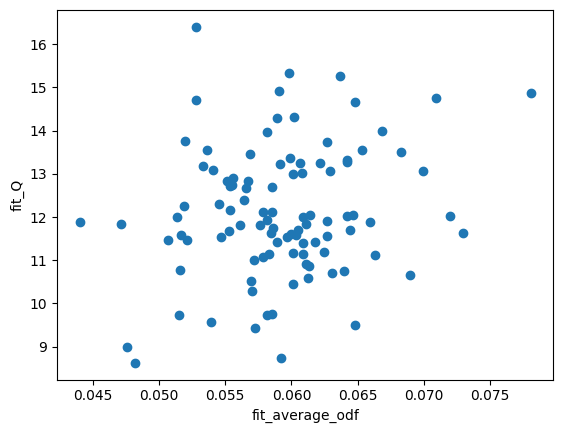

N_GEN = 10
N_GEN = 20
N_GEN = 30
N_GEN = 40
N_GEN = 50
N_GEN = 60
N_GEN = 70
N_GEN = 80
N_GEN = 90
N_GEN = 100


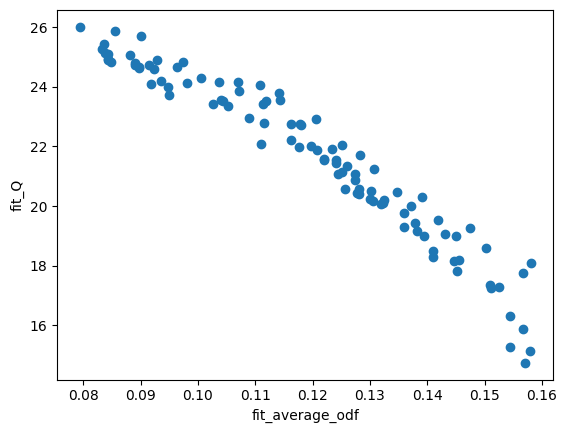

N_GEN = 110
N_GEN = 120
N_GEN = 130
N_GEN = 140
N_GEN = 150
N_GEN = 160
N_GEN = 170
N_GEN = 180
N_GEN = 190
N_GEN = 200


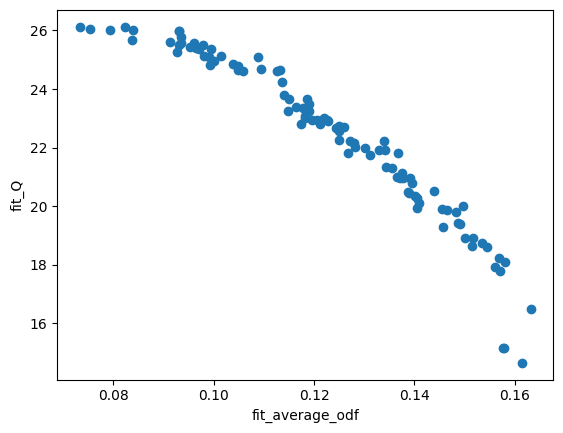

N_GEN = 210
N_GEN = 220
N_GEN = 230
N_GEN = 240
N_GEN = 250


In [22]:
evolved_pop, fitness = evolve(pop, fit_average_odf, fit_Q, amazon_G, conversiones, T=10, n_gen=1, fit1_maximize=False, fit2_maximize=True, pcross=0.7, pmut=0.1, budget=50000)

## Visualización de resultados 

fit1 : [6.37271855014729, 9.805191957165642, 11.848835914257739, 6.683599765537107, 6.885040140458097, 8.432234432234432, 7.168813077603401, 8.009383128948347, 7.1840998462322, 7.141746447996449, 10.21536139299297, 7.179027141159494, 6.393696435143802, 8.7651049887505, 8.796753246753248, 8.003515928515931, 7.2764654463183875, 9.972424153074305, 6.328308261226219, 9.137839864813548, 7.315633671883673, 6.067307322880079, 10.259334946099651, 7.743559218559218, 8.625150470874157, 8.835512943368983, 10.73760328723564, 7.4689256284651036, 6.952194432244743, 6.425949531125723, 5.942026845703317, 7.455537518037517, 7.940017107935064, 9.18482142857143, 7.209906175695648, 11.69543308858324, 10.570048291062221, 6.35948561242679, 8.331250620724306, 10.701356332006485, 7.258925650373019, 6.746265662442134, 10.060214785214782, 10.404852092352092, 7.9985314805966965, 6.593634837384836, 8.191777666777668, 8.884971817827857, 6.088384463181625, 10.744931457431457, 7.46263111888112, 9.856657158630842, 6.

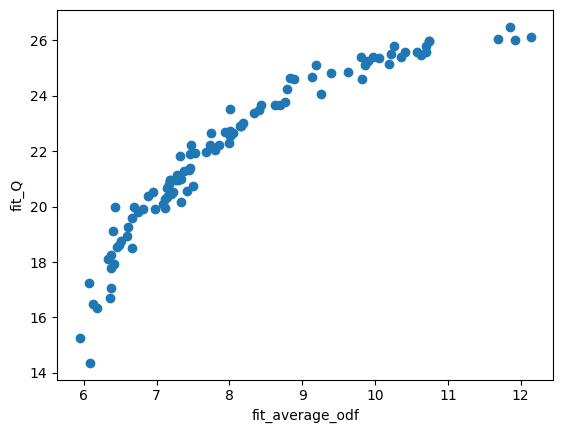

Solución aleatoria para comparar


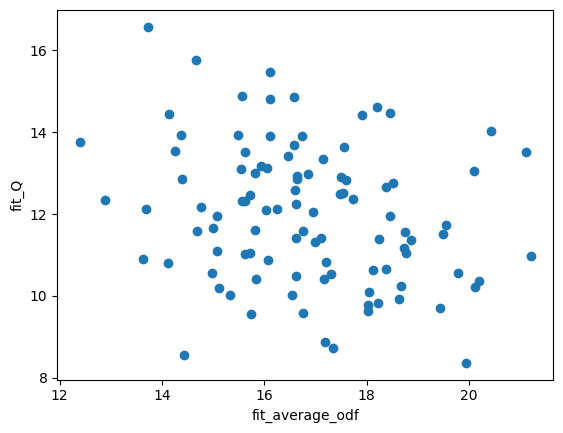

In [23]:
pop = create(amazon_G.nodes, A, conversiones)

fits1 = []
fits2 = []

for ind in evolved_pop:
    fits1.append(fit_average_odf(amazon_G, ind, conversiones))
    fits2.append(fit_Q(amazon_G, ind, conversiones))

print(f"fit1 : {fits1}")
print(f"fit2 : {fits2}")

print("Solución de la última generación")
plt.scatter(fits1, fits2)
plt.xlabel('fit_average_odf')
plt.ylabel('fit_Q')

plt.show()

fits1 = []
fits2 = []

print("Solución aleatoria para comparar")

for ind in pop:
    fits1.append(fit_average_odf(amazon_G, ind, conversiones))
    fits2.append(fit_Q(amazon_G, ind, conversiones))

plt.scatter(fits1, fits2)
plt.xlabel('fit_average_odf')
plt.ylabel('fit_Q')

plt.show()


In [24]:
get_comunidades(evolved_pop[0])

[{0, 154, '182923'},
 {1, 300, '480479'},
 {2, '299055'},
 {3, '33251'},
 {'30962', 4, 65},
 {'379184', 5},
 {204, 305, 33, '394886', 6},
 {224, '389895', 7},
 {'198973', 8, 92},
 {147, '154202', 9},
 {10, 117, '176184'},
 {11, '16457'},
 {12, 420, '83906'},
 {'123681', 13},
 {14, '542780'},
 {15, '196682', 268},
 {'109595', 16},
 {'114378', 17},
 {18, 440, '542633'},
 {19, '475666'},
 {'117287', 20},
 {146, 21, '409356', 430},
 {22, '405178', 413},
 {23, '491667'},
 {104, 215, 24, '99182'},
 {111, 25, '416162'},
 {'141635', 26},
 {27, 296, '30690'},
 {'182201', 279, 28},
 {29, '542026'},
 {122, 30, 387, '448649'},
 {196, 31, '329078'},
 {32, '59532'},
 {197, 34, '60211'},
 {138, '252719', 35},
 {36, '423306'},
 {'225233', 37},
 {38, '532649'},
 {200, 210, '221801', 39},
 {370, 40, '542899'},
 {133, '172218', 376, 41},
 {42, '545994'},
 {188, '250046', 332, 43},
 {113, 217, '256660', 44},
 {'231620', 293, 45},
 {'326849', 46},
 {'142115', 47},
 {287, '346322', 48},
 {'219603', 49},
 {5

# APARTADO C

Ahora lo que haremos será comparar las soluciones del pareto optimo ofrecidas por el algoritmo con el ground truth.

In [25]:
fits = [(fit_Q(amazon_G, ind, conversiones), 1 / (fit_average_odf(amazon_G, ind, conversiones) + 1e-10)) for ind in evolved_pop]
pareto_front, _ = get_pareto_front(evolved_pop, fits)

print(f"El frente de pareto optimo tiene {len(pareto_front)} individuos")

El frente de pareto optimo tiene 35 individuos


Representamos el frente de Pareto de un color distinto

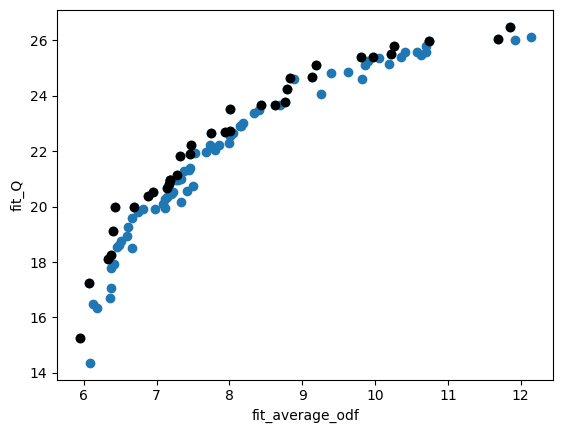

In [26]:
fit1 = [] 
fit2 = [] 
fits1 = [] 
fits2 = [] 
tuplas = []

for ind in pareto_front:
    fit1.append(fit_average_odf(amazon_G, ind, conversiones))
    fit2.append(fit_Q(amazon_G, ind, conversiones))
    tuplas.append((ind, fit1[-1], fit2[-1]))
for ind in evolved_pop:
    fits1.append(fit_average_odf(amazon_G, ind, conversiones))
    fits2.append(fit_Q(amazon_G, ind, conversiones))
plt.scatter(fits1, fits2)
plt.scatter(fit1, fit2, c="#000000")
plt.xlabel('fit_average_odf')
plt.ylabel('fit_Q')

plt.show()


como son muchos para estudiarlos, vamos a establecer un criterio donde podamos quedarnos con solo alguno de ellos. Este criterio será que entre los puntos debe de existir mínimo 0.5 de diferencia en los fitness

In [27]:
tuplas_ordenadas = sorted(tuplas, key=lambda x: x[1])

filtered_pareto = [tuplas_ordenadas[0][0]]
filtered_fits1 = [tuplas_ordenadas[0][1]]

filtered_fits2 = [tuplas_ordenadas[0][2]]

for ind, fit1, fit2 in tuplas_ordenadas:
    if fit1 > filtered_fits1[-1] + 0.5 and fit2 > filtered_fits2[-1] + 0.5:
        filtered_pareto.append(ind)
        filtered_fits1.append(fit1)
        filtered_fits2.append(fit2)


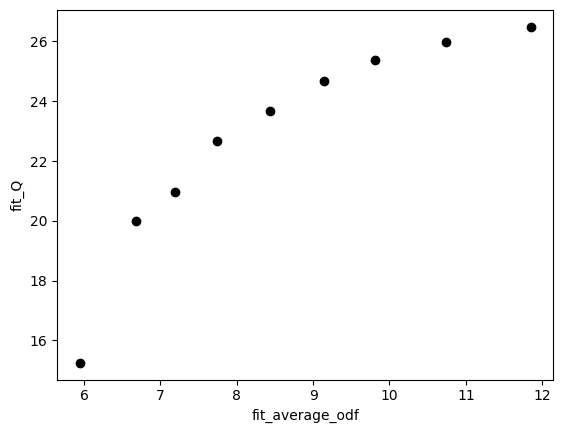

In [28]:

plt.scatter(filtered_fits1, filtered_fits2, c="#000000")
plt.xlabel('fit_average_odf')
plt.ylabel('fit_Q')
plt.show()


Una vez ya tenemos un número menor de soluciones vamos a observar las diferencias con las comunidades de Leiden, creado en la primera parte de la práctica

In [29]:
real_communities = [list() for _ in range(8)]
real_communities

for i in amazon_G.nodes(data=True):
    real_communities[i[1]['community']].append(i[0])
ground_truth = NodeClustering(real_communities, amazon_G)

para el individuo 0 su mutual information es de : MatchingResult(score=0.42224359870890266, std=None)
 N comunidades del genético: 106 vs. 8 reales
para el individuo 1 su mutual information es de : MatchingResult(score=0.40684003889947357, std=None)
 N comunidades del genético: 116 vs. 8 reales
para el individuo 2 su mutual information es de : MatchingResult(score=0.4081774890929902, std=None)
 N comunidades del genético: 101 vs. 8 reales
para el individuo 3 su mutual information es de : MatchingResult(score=0.40112229834262036, std=None)
 N comunidades del genético: 113 vs. 8 reales
para el individuo 4 su mutual information es de : MatchingResult(score=0.40398368534455886, std=None)
 N comunidades del genético: 119 vs. 8 reales
para el individuo 5 su mutual information es de : MatchingResult(score=0.3981487009408983, std=None)
 N comunidades del genético: 120 vs. 8 reales
para el individuo 6 su mutual information es de : MatchingResult(score=0.3908843397486276, std=None)
 N comunidade

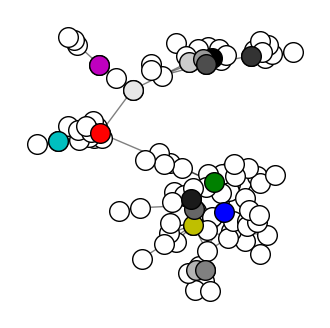

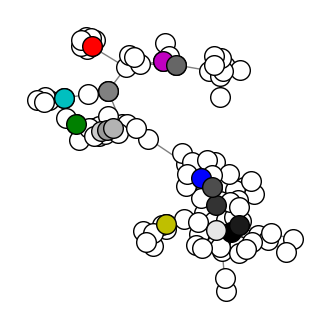

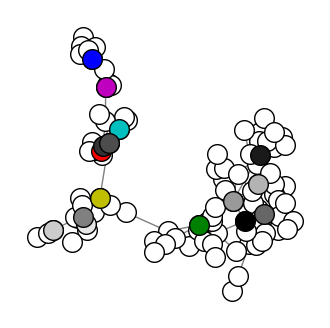

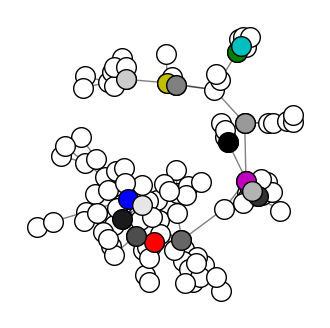

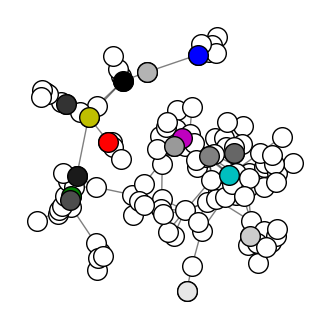

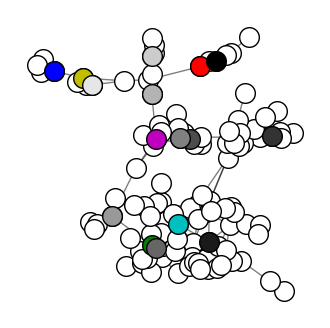

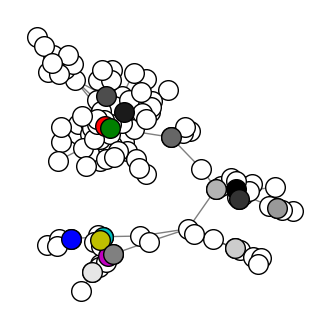

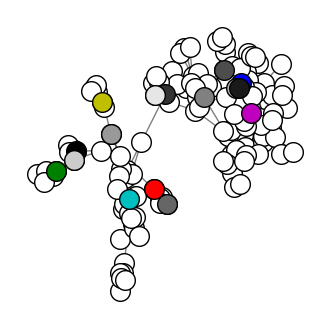

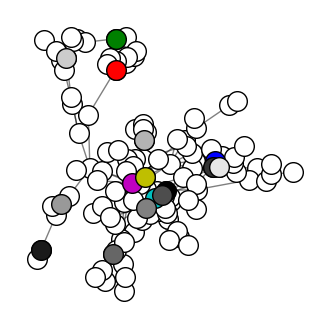

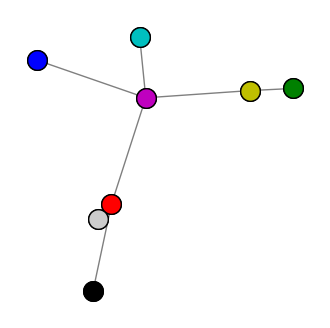

In [30]:
individuo_convertido = [n for n in range(len(filtered_pareto[0]))]
comunidades = []
individuo_convertido = unconvert_individuo(individuo_convertido, conversiones)
for n, ind_pareto in enumerate(filtered_pareto):
    G_genetico = nx.Graph()
    for i, nodo in enumerate(ind_pareto):
        G_genetico.add_edge(individuo_convertido[i], nodo)

    comunidades_genetico = list(nx.connected_components(G_genetico))
    aux = []
    for set_en_lista in comunidades_genetico:
        lista_aux = list(set_en_lista)
        aux.append(lista_aux)
    comunidades_genetico = aux
    node_comunidades_genetico = NodeClustering(comunidades_genetico, amazon_G)
    comunidades.append((comunidades_genetico, node_comunidades_genetico))
    print(f"para el individuo { n } su mutual information es de : {ground_truth.normalized_mutual_information(node_comunidades_genetico)}")
    print(f" N comunidades del genético: {len(comunidades_genetico)} vs. {len(real_communities)} reales")
    viz.plot_community_graph(amazon_G,node_comunidades_genetico, figsize=(4,4))

print("Grafo de comunidades original")
viz.plot_community_graph(amazon_G,ground_truth, figsize=(4,4))

Como vemos tiene una menor correlacion entre el genetico y el creado por leiden. Probando con los 10 individuos del frente vemos que la informacion mutua es mayor según se escogen individuos con mejor fit_average_odf, es decir, más bajo, aunque se penalice reduciendo tambien el Q. En las imágenes vemos como se han creado muchísimas más comunidades que las reales.

recordemos los tamaños de las comunidades:
 ----reales---
comunidad0 -> 35
comunidad1 -> 42
comunidad2 -> 24
comunidad3 -> 8
comunidad4 -> 327
comunidad5 -> 14
comunidad6 -> 16
comunidad7 -> 9
----comunidades de leiden----
comunidad0 -> 50
comunidad1 -> 27
comunidad2 -> 18
comunidad3 -> 17
comunidad4 -> 14
comunidad5 -> 14
comunidad6 -> 14
comunidad7 -> 13
comunidad8 -> 12
comunidad9 -> 12
comunidad10 -> 11
comunidad11 -> 11
comunidad12 -> 11
comunidad13 -> 9
comunidad14 -> 9
comunidad15 -> 8
comunidad16 -> 8
comunidad17 -> 8
comunidad18 -> 8
comunidad19 -> 8
comunidad20 -> 8
comunidad21 -> 7
comunidad22 -> 7
comunidad23 -> 6
comunidad24 -> 6
comunidad25 -> 6
comunidad26 -> 6
comunidad27 -> 6
comunidad28 -> 6
comunidad29 -> 5
comunidad30 -> 5
comunidad31 -> 5
comunidad32 -> 5
comunidad33 -> 5
comunidad34 -> 4
comunidad35 -> 4
comunidad36 -> 4
comunidad37 -> 3
comunidad38 -> 3
comunidad39 -> 3
comunidad40 -> 2
comunidad41 -> 2
comunidad42 -> 2
comunidad43 -> 2
comunidad44 -> 2
comunidad

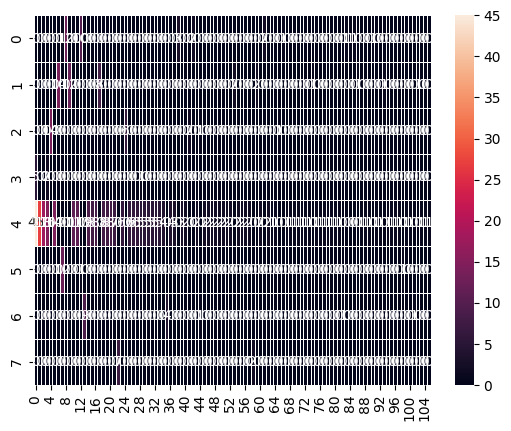

In [31]:
matrix = np.zeros((len(ground_truth.communities), len(comunidades[0][1].communities)))

for node in amazon_G.nodes(data=True):
    i = node[1]['community']
    j = None
    for index, leiden_community in enumerate(comunidades[0][1].communities):
        if node[0] in leiden_community:
            j = index
            break
    matrix[i][j] += 1

sns.heatmap(matrix, annot= True, linewidths=.5)
print(f"recordemos los tamaños de las comunidades:\n ----reales---")
for ind, com in enumerate(real_communities):
    print(f"comunidad{ind} -> {len(com)}")
print(f"----comunidades de leiden----")
for ind, com in enumerate(comunidades[0][1].communities):
    print(f"comunidad{ind} -> {len(com)}")

In [32]:
for index, fila in enumerate(matrix):
    total = np.sum(fila)
    print(f"\nLa comunidad{index} con {total} nodos se ha dividido en:")
    for index, columna in enumerate(fila):
        if columna != 0:
            print(f"comunidad{index} {columna*100 / total}%")


La comunidad0 con 35.0 nodos se ha dividido en:
comunidad7 2.857142857142857%
comunidad8 34.285714285714285%
comunidad12 28.571428571428573%
comunidad38 8.571428571428571%
comunidad42 5.714285714285714%
comunidad61 5.714285714285714%
comunidad66 2.857142857142857%
comunidad83 2.857142857142857%
comunidad84 2.857142857142857%
comunidad85 2.857142857142857%
comunidad90 2.857142857142857%

La comunidad1 con 42.0 nodos se ha dividido en:
comunidad6 33.333333333333336%
comunidad9 28.571428571428573%
comunidad17 19.047619047619047%
comunidad53 4.761904761904762%
comunidad59 4.761904761904762%
comunidad74 2.380952380952381%
comunidad86 2.380952380952381%
comunidad93 2.380952380952381%
comunidad102 2.380952380952381%

La comunidad2 con 24.0 nodos se ha dividido en:
comunidad4 58.333333333333336%
comunidad24 25.0%
comunidad41 8.333333333333334%
comunidad44 4.166666666666667%
comunidad65 4.166666666666667%

La comunidad3 con 8.0 nodos se ha dividido en:
comunidad0 62.5%
comunidad3 25.0%
comunid

Practicamente lo que ha ocurrido es que, en general, las comunidades con muchos nodos las ha partido en muchas comunidades, sobretodo la comunidad más grande donde se ha partido en 80 comunidades.